## Elasticsearch install

In [ ]:
!pip install -U elasticsearch

In [1]:
from elasticsearch import Elasticsearch
es = Elasticsearch()

In [2]:
import requests
res = requests.get('http://localhost:9200')
print(res.content.decode("utf-8"))

{
  "name" : "ASUS",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "iIqVOAu8Q3GC415I7jGCbg",
  "version" : {
    "number" : "6.4.2",
    "build_flavor" : "unknown",
    "build_type" : "unknown",
    "build_hash" : "04711c2",
    "build_date" : "2018-09-26T13:34:09.098244Z",
    "build_snapshot" : false,
    "lucene_version" : "7.4.0",
    "minimum_wire_compatibility_version" : "5.6.0",
    "minimum_index_compatibility_version" : "5.0.0"
  },
  "tagline" : "You Know, for Search"
}



## 匯入 Yelp Dataset 至 Elasticsearch

+ 建立index
+ 讀取每筆pandas資料
+ 寫入elastcsearch

In [3]:
from tqdm import tqdm
import json

In [ ]:
tables = ['business','checkin','photo','review','tip','user']
for table in tqdm(tables):
    data = []
    _ = es.indices.create(index='yelp_'+table , ignore=400)
    with open('D:\Desktop\CGU\碩班\碩二上\毛/yelp_academic_dataset_{}.json'.format(table), encoding='utf-8') as f:
        i = 0
        for line in f:
            result=es.create(index='yelp_'+table,doc_type=table,id=i,body=json.loads(line))
            i += 1
            if i % 5000 == 0:
                print(i, 'records have been uploaded')
    print(table, 'data finished!!!')

## 欲了解 Las Vegas & Toronto 的餐廳與金融類服務店家，其店家分布與滿意程度情況。

[1] 從elasticsearch抓資料出來查詢, by 關鍵字  
[2] 從elasticsearch透過2-layer aggregation進行分析  
[3] 畫一張 heatmap 分析  
[4] 畫一張 histogram 分析  

####  從ealsticsearch抓stars=5

body = {
    "query": {
        "term": {
            "**key**" : "**value**"
        }
    }
}

In [4]:
# 查詢一個精確值: term。 

body = {
    "query":{
        "term":{
            "stars":"5"
        }
    }
}
# 查詢 "stars"="5"的所有資料。

result = es.search(index="yelp_business",body=body)  #將查詢結果存為 result，從 Dataset"yelp_business"查詢，內容(body)=上面 query
result
# es.search(index="yelp_business",body=body)

# 最下方的 'total': 30941為符合條件之資料筆數。

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': '15249',
    '_index': 'yelp_business',
    '_score': 1.0,
    '_source': {'address': '19400 Jetton Rd, Ste 204',
     'attributes': {'BikeParking': 'True',
      'BusinessAcceptsCreditCards': 'True',
      'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
      'Caters': 'False',
      'RestaurantsPriceRange2': '2',
      'RestaurantsTakeOut': 'True',
      'WheelchairAccessible': 'True'},
     'business_id': 'Yh3IX2dg0eLxC9VdTk3gdg',
     'categories': 'Food, Beer, Wine & Spirits',
     'city': 'Cornelius',
     'hours': {'Friday': '11:0-20:0',
      'Monday': '11:0-20:0',
      'Saturday': '11:0-20:0',
      'Sunday': '13:0-18:0',
      'Thursday': '11:0-20:0',
      'Tuesday': '11:0-20:0',
      'Wednesday': '11:0-20:0'},
     'is_open': 1,
     'latitude': 35.476611,
     'longitude': -80.892949,
     'name': 'Winestore',
     'ne

#### 查詢Las Vegas的餐廳平均星等  [3.41]

aaa = {
     "query": {
        "term": {
            "**key A**" : "**value A**"
        }
    },
    "query": {
        "wildcard": {
            "**key B**" : "** *value B ** "
        }
    },
    
    "aggs" : {
        "自行定義" : { "函數" : { "field" : "key" } }
    }
}



LV_Res = es.search(index="**____**", body=aaa,ignore=400)

+ 這裡的query關係為交集，所以key A 與key B的關聯要注意
+ term為精準查詢，後面value必須全相同
+ wildcard為模糊查詢，後面value要有 __*__
+ 函數 sum max min avg ..


In [5]:
aaa = {
     "query":{
        "term":{
            "city.keyword":"Las Vegas"
        }
    },
    "query":{
        "wildcard":{
            "categories.keyword":"*Restaurants"
        }
    },
    
    "aggs" : {
        "types_count" : { "avg" : { "field" : "stars" } }
    }
}



LV_Res = es.search(index="yelp_business", body=aaa,ignore=400)

LV_Res   #最下方'total': 17971為符合條件之總家數。


{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'aggregations': {'types_count': {'value': 3.4102721050581493}},
 'hits': {'hits': [{'_id': '15368',
    '_index': 'yelp_business',
    '_score': 1.0,
    '_source': {'address': '4500 W Tropicana Ave',
     'attributes': {'Alcohol': 'beer_and_wine',
      'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}",
      'BikeParking': 'False',
      'BusinessAcceptsCreditCards': 'True',
      'BusinessParking': "{'garage': True, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
      'Caters': 'False',
      'DriveThru': 'False',
      'GoodForKids': 'True',
      'GoodForMeal': "{'dessert': False, 'latenight': True, 'lunch': True, 'dinner': True, 'breakfast': True, 'brunch': True}",
      'HasTV': 'False',
      'NoiseLevel': 'average',
      'OutdoorSeating': 'False',
      'Restauran

In [6]:
# Los Vegas 餐廳平均滿意度
LV_Res['aggregations']['types_count']['value']

3.4102721050581493

#### 由heatmap與histogram分析 Los Vegas與Toronto的餐廳及金融服務家數與星等
- 先將要的欄位拉出，建立成panda表格，最後再利用panda進行作圖。

In [7]:
# 先將所要的城市與職業類別抓出。 t1為Los Vegas；t2為Toronto
# Las Vegas 中 *Restaurant 或 Financial*
#  'total': 2106

test1 = {
    "query": {
        "bool": {
            "must": [
                {
                    "term": {"city.keyword": "Las Vegas"},
                },
                {
                    "bool": {
                        "should": [
                            {"wildcard": {"categories.keyword": "*Restaurants"}},
                            {"wildcard": {"categories.keyword": "Financial*"}}
                        ]
                    }
                }
            ]
        }
    }
}

t1 = es.search(index="yelp_business",body=test1, size=2106, _source_include=["stars","city","categories"])
t1

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': '4136',
    '_index': 'yelp_business',
    '_score': 2.888186,
    '_source': {'categories': 'Sandwiches, Food, Do-It-Yourself Food, Restaurants',
     'city': 'Las Vegas',
     'stars': 4.0},
    '_type': 'business'},
   {'_id': '5069',
    '_index': 'yelp_business',
    '_score': 2.888186,
    '_source': {'categories': 'Hawaiian, Asian Fusion, Sushi Bars, Restaurants',
     'city': 'Las Vegas',
     'stars': 4.5},
    '_type': 'business'},
   {'_id': '6709',
    '_index': 'yelp_business',
    '_score': 2.888186,
    '_source': {'categories': 'American (New), Restaurants',
     'city': 'Las Vegas',
     'stars': 4.0},
    '_type': 'business'},
   {'_id': '6753',
    '_index': 'yelp_business',
    '_score': 2.888186,
    '_source': {'categories': 'American (Traditional), Restaurants',
     'city': 'Las Vegas',
     'stars': 3.5},
    '_type': 'business'},
   {'_id': '2309',
    '_index': 'y

In [8]:
# Toronto 中 *Restaurant 或 Financial*
# 'total': 2505

test2 = {
    "query": {
        "bool": {
            "must": [
                {
                    "term": {"city.keyword": "Toronto"},
                },
                {
                    "bool": {
                        "should": [
                            {"wildcard": {"categories.keyword": "*Restaurants"}},
                            {"wildcard": {"categories.keyword": "Financial*"}}
                        ]
                    }
                }
            ]
        }
    }
}

t2 = es.search(index="yelp_business", body=test2, size=2505, _source_include=["stars","city","categories"])
t2

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 5, 'total': 5},
 'hits': {'hits': [{'_id': '3111',
    '_index': 'yelp_business',
    '_score': 3.3558419,
    '_source': {'categories': 'Mexican, Restaurants',
     'city': 'Toronto',
     'stars': 3.5},
    '_type': 'business'},
   {'_id': '3440',
    '_index': 'yelp_business',
    '_score': 3.3558419,
    '_source': {'categories': 'Mexican, Restaurants',
     'city': 'Toronto',
     'stars': 2.5},
    '_type': 'business'},
   {'_id': '3750',
    '_index': 'yelp_business',
    '_score': 3.3558419,
    '_source': {'categories': 'Burgers, Breakfast & Brunch, Fast Food, Restaurants',
     'city': 'Toronto',
     'stars': 2.0},
    '_type': 'business'},
   {'_id': '15175',
    '_index': 'yelp_business',
    '_score': 3.3558419,
    '_source': {'categories': 'Burgers, Restaurants',
     'city': 'Toronto',
     'stars': 2.5},
    '_type': 'business'},
   {'_id': '15758',
    '_index': 'yelp_business',
    '_score': 3.3558419,
    '_sour

In [9]:
# 將 t1 & t2 合併
source_dict = {'categories': [], 'city': [], 'stars': []}
for i in t2["hits"]["hits"]:
    source_dict['categories'].append(i['_source']['categories'])
    source_dict['city'].append(i['_source']['city'])
    source_dict['stars'].append(i['_source']['stars'])
del i
for i in t1["hits"]["hits"]:
    source_dict['categories'].append(i['_source']['categories'])
    source_dict['city'].append(i['_source']['city'])
    source_dict['stars'].append(i['_source']['stars'])

In [10]:
source_dict

{'categories': ['Mexican, Restaurants',
  'Mexican, Restaurants',
  'Burgers, Breakfast & Brunch, Fast Food, Restaurants',
  'Burgers, Restaurants',
  'Sushi Bars, Restaurants',
  'Sandwiches, Restaurants',
  'Sushi Bars, Thai, Italian, Restaurants',
  'Fast Food, Sandwiches, Restaurants',
  'Korean, Restaurants',
  'Food, Food Delivery Services, Pizza, Arts & Entertainment, Music Venues, Nightlife, Restaurants',
  'Japanese, Restaurants',
  'Pizza, Restaurants',
  'Italian, Sandwiches, Pizza, Restaurants',
  'Mediterranean, Greek, Burgers, Restaurants',
  'Mexican, Restaurants',
  'Tapas/Small Plates, Restaurants',
  'Mexican, Fast Food, Restaurants',
  'Middle Eastern, Restaurants',
  'Food, Vegan, Cafes, Coffee & Tea, Bakeries, Restaurants',
  'Gastropubs, Restaurants',
  'Greek, Restaurants',
  'Cafes, Shopping, Toy Stores, Hobby Shops, Restaurants',
  'Chinese, Bars, Nightlife, Restaurants',
  'Delicatessen, Food, Fast Food, Sandwiches, Restaurants',
  'Bubble Tea, Food, Juice Bar

In [11]:
# 指定欄位，特定value
source_dict['type'] = []
for i in range(len(source_dict['categories'])):
    if 'Restaurant' in source_dict['categories'][i]:
        source_dict['type'].append('Restaurant')
    elif 'Financial' in source_dict['categories'][i]:
        source_dict['type'].append('Financial')

In [12]:
source_dict

{'categories': ['Mexican, Restaurants',
  'Mexican, Restaurants',
  'Burgers, Breakfast & Brunch, Fast Food, Restaurants',
  'Burgers, Restaurants',
  'Sushi Bars, Restaurants',
  'Sandwiches, Restaurants',
  'Sushi Bars, Thai, Italian, Restaurants',
  'Fast Food, Sandwiches, Restaurants',
  'Korean, Restaurants',
  'Food, Food Delivery Services, Pizza, Arts & Entertainment, Music Venues, Nightlife, Restaurants',
  'Japanese, Restaurants',
  'Pizza, Restaurants',
  'Italian, Sandwiches, Pizza, Restaurants',
  'Mediterranean, Greek, Burgers, Restaurants',
  'Mexican, Restaurants',
  'Tapas/Small Plates, Restaurants',
  'Mexican, Fast Food, Restaurants',
  'Middle Eastern, Restaurants',
  'Food, Vegan, Cafes, Coffee & Tea, Bakeries, Restaurants',
  'Gastropubs, Restaurants',
  'Greek, Restaurants',
  'Cafes, Shopping, Toy Stores, Hobby Shops, Restaurants',
  'Chinese, Bars, Nightlife, Restaurants',
  'Delicatessen, Food, Fast Food, Sandwiches, Restaurants',
  'Bubble Tea, Food, Juice Bar

In [13]:
import pandas as pd
df = pd.DataFrame.from_records(source_dict)
df = df.drop('categories', axis=1)   #刪除categories欄位
df.head()

,city,stars,type
0,Toronto,3.5,Restaurant
1,Toronto,2.5,Restaurant
2,Toronto,2.0,Restaurant
3,Toronto,2.5,Restaurant
4,Toronto,3.5,Restaurant


In [14]:
df.groupby('city').describe()

stars                                             
            count      mean       std  min  25%  50%  75%  max
city                                                          
Las Vegas  2106.0  3.401235  0.868547  1.0  3.0  3.5  4.0  5.0
Toronto    2505.0  3.368463  0.765393  1.0  3.0  3.5  4.0  5.0

In [15]:
df.groupby('type').describe()

stars                                             
             count      mean       std  min  25%  50%  75%  max
type                                                           
Financial    285.0  3.287719  1.245989  1.0  2.5  3.0  4.5  5.0
Restaurant  4326.0  3.389736  0.777190  1.0  3.0  3.5  4.0  5.0

In [16]:
df.groupby(['city','type']).describe()

stars                                             
                       count      mean       std  min  25%  50%  75%  max
city      type                                                           
Las Vegas Financial    244.0  3.411885  1.208433  1.0  2.5  3.5  4.5  5.0
          Restaurant  1862.0  3.399839  0.813993  1.0  3.0  3.5  4.0  5.0
Toronto   Financial     41.0  2.548780  1.223749  1.0  1.5  2.5  3.0  5.0
          Restaurant  2464.0  3.382102  0.748256  1.0  3.0  3.5  4.0  5.0

In [17]:
df_stars_type = df.groupby(['stars','type']).describe()
df_stars_type
# df_stars.city.top

city                       
                 count unique        top freq
stars type                                   
1.0   Financial     17      2  Las Vegas   12
      Restaurant    25      2    Toronto   14
1.5   Financial     14      2  Las Vegas    8
      Restaurant    87      2    Toronto   49
2.0   Financial     35      2  Las Vegas   26
      Restaurant   287      2    Toronto  145
2.5   Financial     43      2  Las Vegas   35
      Restaurant   453      2    Toronto  233
3.0   Financial     37      2  Las Vegas   33
      Restaurant   819      2    Toronto  517
3.5   Financial     30      2  Las Vegas   28
      Restaurant  1129      2    Toronto  691
4.0   Financial     28      2  Las Vegas   27
      Restaurant  1030      2    Toronto  570
4.5   Financial     23      2  Las Vegas   22
      Restaurant   413      2  Las Vegas  211
5.0   Financial     58      2  Las Vegas   53
      Restaurant    83      2    Toronto   43

In [18]:
df_stars = df.groupby(['stars']).describe()
df_stars
# df_stars.city.top

city                         type                         
      count unique        top freq count unique         top  freq
stars                                                            
1.0      42      2  Las Vegas   23    42      2  Restaurant    25
1.5     101      2    Toronto   55   101      2  Restaurant    87
2.0     322      2  Las Vegas  168   322      2  Restaurant   287
2.5     496      2  Las Vegas  255   496      2  Restaurant   453
3.0     856      2    Toronto  521   856      2  Restaurant   819
3.5    1159      2    Toronto  693  1159      2  Restaurant  1129
4.0    1058      2    Toronto  571  1058      2  Restaurant  1030
4.5     436      2  Las Vegas  233   436      2  Restaurant   413
5.0     141      2  Las Vegas   93   141      2  Restaurant    83

In [19]:
df_stars.loc[:, ('city', 'minor')] = df_stars.loc[:, ('city', 'count')] - df_stars.loc[:, ('city', 'freq')]
df_stars.loc[:, ('city', 'minor')]


# for i in list(df_stars.index):
#     if df_stars.loc[i, ('city', 'top')] == 'Las Vegas':
#         df_stars.loc[i, ('city', 'second')] = 'Toronto'
#     elif df_stars.loc[i, ('city', 'top')] == 'Toronto':
#         df_stars.loc[i, ('city', 'second')] = 'Las Vegas'

df_stars.loc[:, ('city', 'Las Vegas')] = [23, 46, 168, 255, 335, 466, 487, 233, 93]
df_stars.loc[:, ('city', 'Toronto')] = [19, 55, 154, 241, 521, 693, 571, 203, 48]
df_stars

city                         type                           city  \
      count unique        top freq count unique         top  freq minor   
stars                                                                     
1.0      42      2  Las Vegas   23    42      2  Restaurant    25    19   
1.5     101      2    Toronto   55   101      2  Restaurant    87    46   
2.0     322      2  Las Vegas  168   322      2  Restaurant   287   154   
2.5     496      2  Las Vegas  255   496      2  Restaurant   453   241   
3.0     856      2    Toronto  521   856      2  Restaurant   819   335   
3.5    1159      2    Toronto  693  1159      2  Restaurant  1129   466   
4.0    1058      2    Toronto  571  1058      2  Restaurant  1030   487   
4.5     436      2  Las Vegas  233   436      2  Restaurant   413   203   
5.0     141      2  Las Vegas   93   141      2  Restaurant    83    48   

                         
      Las Vegas Toronto  
stars                    
1.0          23      19  
1.5          46      55  
2.0         168     154  
2.5         255     241  
3.0         335     521  
3.5         466     693  
4.0         487     571  
4.5         233     203  
5.0          93      48

In [22]:
# df_stars.loc[:, ('city', 'top')]

stars
1.0    Las Vegas
1.5      Toronto
2.0    Las Vegas
2.5    Las Vegas
3.0      Toronto
3.5      Toronto
4.0      Toronto
4.5    Las Vegas
5.0    Las Vegas
Name: (city, top), dtype: object

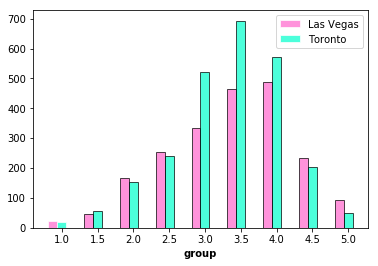

In [191]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = df_stars.loc[:, ('city', 'Las Vegas')]
bars2 = df_stars.loc[:, ('city', 'Toronto')]
 
# Set position of bar on X axis
r1 = np.arange(len(df_stars.loc[:, ('city', 'Las Vegas')]))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#ff66cc', alpha=0.7, width=barWidth, edgecolor='white', label='Las Vegas')
plt.bar(r2, bars2, color='#00ffcc', alpha=0.7, width=barWidth, edgecolor='white', label='Toronto')

 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

# import plotly.tools as tls
# from plotly.offline import init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# fig = plt.gcf()
# plotly_fig = tls.mpl_to_plotly(fig)
# iplot(plotly_fig, filename='stars distribution by city')

In [24]:
# df_stars.loc[:, ('city', 'Las Vegas')]

stars
1.0     23
1.5     46
2.0    168
2.5    255
3.0    335
3.5    466
4.0    487
4.5    233
5.0     93
Name: (city, Las Vegas), dtype: int64

In [190]:
# 全都市平均星等(不分服務類型)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'],
    y=df_stars.loc[:, ('city', 'Las Vegas')] / df_stars.loc[:, ('city', 'Las Vegas')].sum(),
    name='Las Vegas',
    marker=dict(
        color='#ff66cc'
    ),
    opacity=0.7
)

trace2 = go.Bar(
    x=['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'],
    y=df_stars.loc[:, ('city', 'Toronto')] / df_stars.loc[:, ('city', 'Toronto')].sum(),
    name='Toronto',
    marker=dict(
        color='#00ffcc'
    ),
    opacity=0.7
)

data = [trace1, trace2]
layout = go.Layout(
    title='Percentage of Restaurants & Financial Services Stars Distibution by City',
    barmode='group',
    yaxis = dict(
        tickformat=',.0%',
        range=[0,0.3]
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stars-by-grouped-bar')

In [26]:
df_stars_type.loc[:, ('city', 'minor')] = df_stars_type.loc[:, ('city', 'count')] - df_stars_type.loc[:, ('city', 'freq')]
df_stars_type.loc[:, ('city', 'minor')]


# for i in list(df_stars.index):
#     if df_stars.loc[i, ('city', 'top')] == 'Las Vegas':
#         df_stars.loc[i, ('city', 'second')] = 'Toronto'
#     elif df_stars.loc[i, ('city', 'top')] == 'Toronto':
#         df_stars.loc[i, ('city', 'second')] = 'Las Vegas'

df_stars_type.loc[:, ('city', 'Las Vegas_R')] = [0, 11, 0, 38, 0, 142, 0, 220, 0, 302, 0, 438, 0, 460, 0, 211, 0, 40]
df_stars_type.loc[:, ('city', 'Toronto_R')] = [0, 14, 0, 49, 0, 145, 0, 233, 0, 517, 0, 691, 0, 570, 0, 202, 0, 43]
df_stars_type.loc[:, ('city', 'Las Vegas_F')] = [12, 0, 8, 0, 26, 0, 35, 0, 33, 0, 28, 0, 27, 0, 22, 0, 53, 0]
df_stars_type.loc[:, ('city', 'Toronto_F')] = [5, 0, 6, 0, 9, 0, 8, 0, 4, 0, 2, 0, 1, 0, 1, 0, 5, 0]
df_stars_type

city                                                     \
                 count unique        top freq minor Las Vegas_R Toronto_R   
stars type                                                                  
1.0   Financial     17      2  Las Vegas   12     5           0         0   
      Restaurant    25      2    Toronto   14    11          11        14   
1.5   Financial     14      2  Las Vegas    8     6           0         0   
      Restaurant    87      2    Toronto   49    38          38        49   
2.0   Financial     35      2  Las Vegas   26     9           0         0   
      Restaurant   287      2    Toronto  145   142         142       145   
2.5   Financial     43      2  Las Vegas   35     8           0         0   
      Restaurant   453      2    Toronto  233   220         220       233   
3.0   Financial     37      2  Las Vegas   33     4           0         0   
      Restaurant   819      2    Toronto  517   302         302       517   
3.5   Financial     30      2  Las Vegas   28     2           0         0   
      Restaurant  1129      2    Toronto  691   438         438       691   
4.0   Financial     28      2  Las Vegas   27     1           0         0   
      Restaurant  1030      2    Toronto  570   460         460       570   
4.5   Financial     23      2  Las Vegas   22     1           0         0   
      Restaurant   413      2  Las Vegas  211   202         211       202   
5.0   Financial     58      2  Las Vegas   53     5           0         0   
      Restaurant    83      2    Toronto   43    40          40        43   

                                        
                 Las Vegas_F Toronto_F  
stars type                              
1.0   Financial           12         5  
      Restaurant           0         0  
1.5   Financial            8         6  
      Restaurant           0         0  
2.0   Financial           26         9  
      Restaurant           0         0  
2.5   Financial           35         8  
      Restaurant           0         0  
3.0   Financial           33         4  
      Restaurant           0         0  
3.5   Financial           28         2  
      Restaurant           0         0  
4.0   Financial           27         1  
      Restaurant           0         0  
4.5   Financial           22         1  
      Restaurant           0         0  
5.0   Financial           53         5  
      Restaurant           0         0

In [192]:
# 比較同為餐廳，但不同據點的星等
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['', '1.0','', '1.5','', '2.0','', '2.5','', '3.0','', '3.5','', '4.0','', '4.5','', '5.0'],
    y=df_stars_type.loc[:, ('city', 'Las Vegas_R')] / df_stars_type.loc[:, ('city', 'Las Vegas_R')].sum(),
    name='Las Vegas',
    marker=dict(
        color='#ff66cc'
    ),
    opacity=0.7
)

trace2 = go.Bar(
    x=['', '1.0','', '1.5','', '2.0','', '2.5','', '3.0','', '3.5','', '4.0','', '4.5','', '5.0'],
    y=df_stars_type.loc[:, ('city', 'Toronto_R')] / df_stars_type.loc[:, ('city', 'Toronto_R')].sum(),
    name='Toronto',
    marker=dict(
        color='#00ffcc'
    ),
    opacity=0.7
)

data = [trace1, trace2]
layout = go.Layout(
    title='Stars by Restaurant sites in percentage',
    barmode='group',
    xaxis=dict(
        title='Stars'
    ),
    yaxis = dict(
        tickformat=',.0%',
        range=[0,0.3]
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stars-by-restaurant-sites-rouped-bar in percentage')

In [193]:
# 比較同為金融服務，但不同據點的星等
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=['1.0','', '1.5', '', '2.0','','2.5', '', '3.0','', '3.5','', '4.0','', '4.5','', '5.0',''],
    y=df_stars_type.loc[:, ('city', 'Las Vegas_F')] / df_stars_type.loc[:, ('city', 'Las Vegas_F')].sum(),
    name='Las Vegas',
    marker=dict(
        color='#ff66cc'
    ),
    opacity=0.7
)

trace2 = go.Bar(
    x=['1.0','', '1.5', '', '2.0','','2.5', '', '3.0','', '3.5','', '4.0','', '4.5','', '5.0',''],
    y=df_stars_type.loc[:, ('city', 'Toronto_F')] / df_stars_type.loc[:, ('city', 'Toronto_F')].sum(),
    name='Toronto',
    marker=dict(
        color='#00ffcc'
    ),
    opacity=0.7
)

data = [trace1, trace2]
layout = go.Layout(
    title='Stars by Financial Service sites ',
    barmode='group',
    xaxis=dict(
        title='Stars'
    ),
    yaxis = dict(
        tickformat=',.0%',
        range=[0,0.3]
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stars-by-Financial Service-sites-rouped-bar')

### heatmap: 所有城市餐廳的星等及所在地的熱區分析

In [148]:
body = {
    "query":{
         "bool":{
            "must":[
                {
                    "terms":{
                        "_id": [str(i) for i in list(range(0,100000))]
                    }
                },
                {
                    "wildcard":{
                        "categories.keyword":"*Restaurants"
                    }
                }
            ]
         }
    }
}


result1 = es.search(index="yelp_business",body=body,size=10000)  

In [149]:
len(result1['hits']['hits'])

9780

In [151]:
body = {
    "query":{
         "bool":{
            "must":[
                {
                    "terms":{
                        "_id": [str(i) for i in list(range(100000,188593))]
                    }
                },
                {
                    "wildcard":{
                        "categories.keyword":"*Restaurants"
                    }
                }
            ]
         }
    }
}
# id = 10000~188593, check後 17971-9780=8191。

result2 = es.search(index="yelp_business",body=body,size=10000)  

In [152]:
len(result2['hits']['hits'])

8191

In [153]:
res_dict = {'categories': [],'city': [], 'stars': []}
for i in result1['hits']['hits']:
    res_dict['categories'].append(i['_source']['categories'])
    res_dict['city'].append(i['_source']['city'])
    res_dict['stars'].append(i['_source']['stars'])

del i

for i in result2['hits']['hits']:
    res_dict['categories'].append(i['_source']['categories'])
    res_dict['city'].append(i['_source']['city'])
    res_dict['stars'].append(i['_source']['stars'])

res_dict

{'categories': ['American (New), Burgers, Cafes, Breakfast & Brunch, Restaurants',
  'Diners, Restaurants',
  'Mexican, Restaurants',
  'Chinese, Restaurants',
  'Pizza, Restaurants',
  'Buffets, Restaurants',
  'Middle Eastern, Restaurants',
  'Coffee & Tea, Food, Vegetarian, Sandwiches, Breakfast & Brunch, Desserts, Restaurants',
  'Chinese, Japanese, Asian Fusion, Malaysian, Singaporean, Sushi Bars, Restaurants',
  'Pizza, Mediterranean, Italian, Restaurants',
  'Cafes, Restaurants',
  'Pizza, American (Traditional), Restaurants',
  'Burgers, Hot Dogs, Restaurants',
  'Sandwiches, Delis, Beer, Wine & Spirits, Food, Restaurants',
  'Pizza, Sandwiches, Italian, Restaurants',
  'American (Traditional), Restaurants',
  'Cafes, Restaurants',
  'Chinese, Restaurants',
  'Burgers, American (Traditional), Restaurants',
  'Pizza, Restaurants',
  'Noodles, Italian, Restaurants',
  'French, Event Planning & Services, Breakfast & Brunch, Caterers, Restaurants',
  'Greek, Italian, Restaurants',


In [154]:
df = pd.DataFrame.from_records(res_dict)
df

,categories,city,stars
0,"American (New), Burgers, Cafes, Breakfast & Br...",Las Vegas,3.5
1,"Diners, Restaurants",Willoughby,2.0
2,"Mexican, Restaurants",Las Vegas,3.5
3,"Chinese, Restaurants",Surprise,3.0
4,"Pizza, Restaurants",Phoenix,4.5
5,"Buffets, Restaurants",Las Vegas,3.0
6,"Middle Eastern, Restaurants",Toronto,2.0
7,"Coffee & Tea, Food, Vegetarian, Sandwiches, Br...",Bay Village,4.0
8,"Chinese, Japanese, Asian Fusion, Malaysian, Si...",Kent,4.5
9,"Pizza, Mediterranean, Italian, Restaurants",Toronto,4.0


In [156]:
del result1, result2

In [155]:
df.groupby(['city','stars']).describe()

# df_res_stars = df.groupby(['stars']).describe()
# df_res_stars

categories         \
                            count unique   
city             stars                     
                 2.5            1      1   
                 4.5            1      1   
AGINCOURT        2.0            1      1   
Ahwatukee        4.0            1      1   
Airdrie          2.0            3      2   
                 2.5            1      1   
                 3.0            5      5   
                 3.5            9      9   
                 4.0            4      4   
                 4.5            5      5   
                 5.0            1      1   
Ajax             1.5            3      3   
                 2.0            2      2   
                 2.5            5      5   
                 3.0           12     12   
                 3.5            5      5   
                 4.0            8      8   
                 4.5            9      9   
                 5.0            1      1   
Allison Park     3.0            2      2   
                 3.5            2      2   
                 4.0            1      1   
                 4.5            2      2   
                 5.0            1      1   
Ambridge         2.5            1      1   
                 3.0            2      2   
                 3.5            1      1   
                 4.5            1      1   
Amherst          2.0            3      3   
                 2.5            1      1   
...                           ...    ...   
Willowick        5.0            1      1   
Windsor          4.0            1      1   
Woodbridge       2.0            1      1   
                 2.5            2      2   
                 3.0           10      8   
                 3.5            6      5   
                 4.0            5      5   
                 4.5            4      4   
                 5.0            3      2   
Woodmere         3.0            2      2   
                 3.5            1      1   
                 4.0            1      1   
Woodmere Village 3.5            1      1   
York             2.0            1      1   
                 3.0            2      2   
                 3.5            6      6   
                 4.0            8      6   
                 4.5            3      3   
                 5.0            2      2   
Youngtown        4.0            2      2   
                 4.5            1      1   
clinton          3.0            1      1   
                 4.0            1      1   
columbia station 3.0            1      1   
                 3.5            1      1   
                 4.0            1      1   
las vegas        2.5            1      1   
                 3.5            1      1   
toronto          3.5            1      1   
vaughan          3.5            1      1   

                                                                                
                                                                      top freq  
city             stars                                                          
                 2.5         Burgers, American (Traditional), Restaurants    1  
                 4.5                                 Mexican, Restaurants    1  
AGINCOURT        2.0                      Fast Food, Burgers, Restaurants    1  
Ahwatukee        4.0           Creperies, Coffee & Tea, Food, Restaurants    1  
Airdrie          2.0                                   Pizza, Restaurants    2  
                 2.5                      Fast Food, Burgers, Restaurants    1  
                 3.0                          Pizza, Italian, Restaurants    1  
                 3.5                                   Cafes, Restaurants    1  
                 4.0                                  Indian, Restaurants    1  
                 4.5                        Korean, Barbeque, Restaurants    1  
                 5.0              Sushi Bars, Japanese, Food, Restaurants    1  
Ajax             1.5                               Caribbean, Restaurant

In [161]:
pd.crosstab(df['city'],df['stars'])

stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
city,,,,,,,,,
,0,0,0,1,0,0,0,1,0
AGINCOURT,0,0,1,0,0,0,0,0,0
Ahwatukee,0,0,0,0,0,0,1,0,0
Airdrie,0,0,3,1,5,9,4,5,1
Ajax,0,3,2,5,12,5,8,9,1
Allison Park,0,0,0,0,2,2,1,2,1
Ambridge,0,0,0,1,2,1,0,1,0
Amherst,0,0,3,1,3,4,4,3,1
Ange-Gardien,0,1,0,0,0,0,0,0,0


In [178]:
list(df[['city','stars']].groupby(['city']).count().nlargest(10, 'stars').index)

['Toronto',
 'Las Vegas',
 'Montréal',
 'Phoenix',
 'Calgary',
 'Charlotte',
 'Pittsburgh',
 'Mississauga',
 'Cleveland',
 'Scottsdale']

In [181]:
top10 = df[df['city'].isin(list(df[['city','stars']].groupby(['city']).count().nlargest(10, 'stars').index))]

,categories,city,stars
0,"American (New), Burgers, Cafes, Breakfast & Br...",Las Vegas,3.5
2,"Mexican, Restaurants",Las Vegas,3.5
4,"Pizza, Restaurants",Phoenix,4.5
5,"Buffets, Restaurants",Las Vegas,3.0
6,"Middle Eastern, Restaurants",Toronto,2.0
9,"Pizza, Mediterranean, Italian, Restaurants",Toronto,4.0
10,"Cafes, Restaurants",Phoenix,4.5
12,"Burgers, Hot Dogs, Restaurants",Pittsburgh,4.0
16,"Cafes, Restaurants",Montréal,3.0
18,"Burgers, American (Traditional), Restaurants",Montréal,3.0


In [184]:
pd.crosstab(top10['city'],top10['stars'])

stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
city,,,,,,,,,
Calgary,5,15,41,83,182,261,214,105,20
Charlotte,8,23,54,85,131,191,177,78,15
Cleveland,9,20,22,42,67,94,110,56,12
Las Vegas,11,38,142,220,302,438,460,211,40
Mississauga,3,9,22,68,85,106,100,42,7
Montréal,4,20,43,96,160,272,374,190,39
Phoenix,6,28,91,114,214,247,278,131,28
Pittsburgh,2,12,34,56,114,187,175,90,18
Scottsdale,0,1,10,40,66,132,136,41,3


In [185]:
pd.crosstab(top10['city'],top10['stars']).values

array([[  5,  15,  41,  83, 182, 261, 214, 105,  20],
       [  8,  23,  54,  85, 131, 191, 177,  78,  15],
       [  9,  20,  22,  42,  67,  94, 110,  56,  12],
       [ 11,  38, 142, 220, 302, 438, 460, 211,  40],
       [  3,   9,  22,  68,  85, 106, 100,  42,   7],
       [  4,  20,  43,  96, 160, 272, 374, 190,  39],
       [  6,  28,  91, 114, 214, 247, 278, 131,  28],
       [  2,  12,  34,  56, 114, 187, 175,  90,  18],
       [  0,   1,  10,  40,  66, 132, 136,  41,   3],
       [ 14,  49, 145, 233, 517, 691, 570, 202,  43]], dtype=int64)

In [186]:
pd.crosstab(top10['city'],top10['stars']).columns

Float64Index([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], dtype='float64', name='stars')

In [187]:
pd.crosstab(top10['city'],top10['stars']).index

Index(['Calgary', 'Charlotte', 'Cleveland', 'Las Vegas', 'Mississauga',
       'Montréal', 'Phoenix', 'Pittsburgh', 'Scottsdale', 'Toronto'],
      dtype='object', name='city')

In [189]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

trace = go.Heatmap(z=pd.crosstab(top10['city'],top10['stars']).values,
                   x=list(pd.crosstab(top10['city'],top10['stars']).columns),
                   y=list(pd.crosstab(top10['city'],top10['stars']).index),
                   colorscale=[[0, 'rgb(165,0,38)'], [100, 'rgb(215,48,39)'], [200, 'rgb(244,109,67)'], [300, 'rgb(253,174,97)'], [400, 'rgb(254,224,144)'], [500, 'rgb(224,243,248)'], [600, 'rgb(171,217,233)'], [700, 'rgb(116,173,209)'], [800, 'rgb(69,117,180)'], [900, 'rgb(49,54,149)']]
                  )
data=[trace]
iplot(data, filename='labelled-heatmap')